# Tourist satisfaction with transport systems to Mount Etna, Sicily. Part 1. NLP.

# This cell will prompt you to connect this notebook with your google account.
from google.colab import drive                                                                        
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Academy/+ Papers/en_proceso/mount_etna/'


In [1]:
base_dir = '../' # To run locally

# 1. Data pre-processing

In [2]:
#!pip install pycaret[full]

## Importing libraries

In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import spacy
#spacy.load("en_core_web_sm")


# NLTK
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet, stopwords
from collections import Counter
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

#ignore log(0) and divide by 0 warning
np.seterr(divide = 'ignore');
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

print('Libraries read!')

Libraries read!


[nltk_data] Downloading package stopwords to /home/juan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/juan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/juan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /home/juan/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/juan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Reading data

In [5]:
data = pd.read_csv(base_dir + 'data/mount_etna.csv')
data = data[['author', 'title', 'content', 'rating']]

# Dropping rows without data in content
data = data.dropna(subset = ['content']).reset_index(drop=True)

print('Data shape: ', data.shape)
data.head()

Data shape:  (3419, 4)


author                                              title  \
0  Michele Amico🇮🇹🇮🇹🇮🇹🇮🇹                                             Etna🇮🇹   
1               Teithiwr                         A hard climb, but worth it   
2      elizabethlascheid  You must see an active volcano at least once i...   
3                 Anne N                    Cost of cable car to the top???   
4  Michele Amico🇮🇹🇮🇹🇮🇹🇮🇹                                     Wonderful Etna   

                                             content  rating  
0  East side of the sicilian island, in the Catan...       5  
1  August 2008. Arrived at Refugio Sapienza just ...       4  
2  Mount Etna is extraordinary. It is an active v...       5  
3  How much does the cable car cost from Rifugio ...       4  
4  It's always a great and sensational emotion to...       5

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3419 entries, 0 to 3418
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   author   3417 non-null   object
 1   title    3419 non-null   object
 2   content  3419 non-null   object
 3   rating   3419 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 133.6+ KB


# Filtering comments using EACH keyword, to assess imbalance in dataset

In [6]:
TRANSPORT_KEYWORD = ['transport', 'cable', 'car', 'rail', 'bus', 'transportation', 'mobility', 'bike']


for i in TRANSPORT_KEYWORD:
    # Filtering
    data_filtered = data.copy()
    data_filtered['is_transport_related'] = data_filtered['content'].str.contains(i, case=False, na=False)
    data_filtered = data_filtered[data_filtered['is_transport_related']==True].reset_index(drop=True)
    data_filtered = data_filtered.drop(columns=['is_transport_related'])

    # Creating sentiment_rating feature based on rating
    data_filtered['sentiment_rating'] = np.where(data_filtered['rating'] > 3,1,0)
    #TODO dejar solo 1 y 2 para negativo para tratar de mejorar metricas

    # changing bad and good just for visualization in the recall metric
    data_filtered['sentiment_rating'] = data_filtered['sentiment_rating'].replace([0,1],['negative', 'positive'])
    data_filtered['sentiment_rating'] = data_filtered['sentiment_rating'].replace(['negative','positive'],[1, 0]) # NEGATIVE IS 1!!!!



    # Printing datasets    
    print('Dataset using keyword: {}.'.format(i))
    print('Data shape: ', data_filtered.shape)
    print(data_filtered['sentiment_rating'].value_counts(normalize=True))
    display(data_filtered.head(10))
    print('--------------')

Dataset using keyword: transport.
Data shape:  (76, 5)
0    0.907895
1    0.092105
Name: sentiment_rating, dtype: float64


author                                              title  \
0           John O  Mount Etna - AST bus from Catania, cable car a...   
1  Faithalicious_x  More fun than I was expecting, easy enough by ...   
2            lihte                                 top craters - etna   
3          Kathy R  Memorable day in Etna & Taormina with Sicily Life   
4      relloggrion                                              GREAT   
5          Makence                           Loved our stay in Sicily   
6         VikramVI  How can you make visit awesome, lots of tips f...   
7          Donna K                                    The Full Monte    
8        Bath_Rich          Unbelievable and unforgettable experience   
9        Quentin C  Definitely Take a Guided Tour for the Best Exp...   

                                             content  rating  sentiment_rating  
0  Mount Etna is a stunning day out from Catania....       4                 0  
1  I arrived at Etna using public transport and v...       5                 0  
2  Hi,,We have just climbed etna on the 6th of ju...       5                 0  
3  Kudos to Sicily Life for providing my group of...       5                 0  
4  we visited mount Etna in August 2010 and had a...       4                 0  
5  Me and my boyfriend went to Sicily at the end ...       5                 0  
6  - You can make your trip to this must visit Vo...       5                 0  
7  Really enjoyed the trip to Mount Etna. The sce...       4                 0  
8  This is the main reason I wanted to visit Sici...       5                 0  
9  My family and I considered going up Mt. Etna b...       5                 0

--------------
Dataset using keyword: cable.
Data shape:  (1352, 5)
0    0.888314
1    0.111686
Name: sentiment_rating, dtype: float64


author                                              title  \
0       Teithiwr                         A hard climb, but worth it   
1         Anne N                    Cost of cable car to the top???   
2  doorstomanual                       Well orgainised, easy access   
3       Emilie P                   Cheap and easy way to do Mt Etna   
4     Jonathan L        Question about Etna Cable Cars and children   
5         John O  Mount Etna - AST bus from Catania, cable car a...   
6       koenevie                        walk mount etna on your own   
7         Gunnel                                           Stunning   
8         Agil N            Spectacular drive up Mount Etna, Sicily   
9    tugcrumpton  One earring to rule them all but take a coat a...   

                                             content  rating  sentiment_rating  
0  August 2008. Arrived at Refugio Sapienza just ...       4                 0  
1  How much does the cable car cost from Rifugio ...       4                 0  
2  We visited Etna with two small children in Aug...       5                 0  
3  We were able to experience Mt Etna without spe...       5                 0  
4  We would like to visit Etna. We have a 3 year ...       5                 0  
5  Mount Etna is a stunning day out from Catania....       4                 0  
6  If you are in good condition, you can climb th...       5                 0  
7  We stayed at Nicolosi 25 k's from Mt Etna. It ...       5                 0  
8  We wanted to see Mount Etna whilst holidaying ...       4                 0  
9  My beloved and I were chatting about various t...       4                 0

--------------
Dataset using keyword: car.
Data shape:  (1629, 5)
0    0.897483
1    0.102517
Name: sentiment_rating, dtype: float64


author                                              title  \
0           Teithiwr                         A hard climb, but worth it   
1  elizabethlascheid  You must see an active volcano at least once i...   
2             Anne N                    Cost of cable car to the top???   
3      doorstomanual                       Well orgainised, easy access   
4           Emilie P                   Cheap and easy way to do Mt Etna   
5         Jonathan L        Question about Etna Cable Cars and children   
6             John O  Mount Etna - AST bus from Catania, cable car a...   
7           koenevie                        walk mount etna on your own   
8             Gunnel                                           Stunning   
9             Agil N            Spectacular drive up Mount Etna, Sicily   

                                             content  rating  sentiment_rating  
0  August 2008. Arrived at Refugio Sapienza just ...       4                 0  
1  Mount Etna is extraordinary. It is an active v...       5                 0  
2  How much does the cable car cost from Rifugio ...       4                 0  
3  We visited Etna with two small children in Aug...       5                 0  
4  We were able to experience Mt Etna without spe...       5                 0  
5  We would like to visit Etna. We have a 3 year ...       5                 0  
6  Mount Etna is a stunning day out from Catania....       4                 0  
7  If you are in good condition, you can climb th...       5                 0  
8  We stayed at Nicolosi 25 k's from Mt Etna. It ...       5                 0  
9  We wanted to see Mount Etna whilst holidaying ...       4                 0

--------------
Dataset using keyword: rail.
Data shape:  (95, 5)
0    0.947368
1    0.052632
Name: sentiment_rating, dtype: float64


author                                              title  \
0  elizabethlascheid  You must see an active volcano at least once i...   
1         Itchy2Feet                        Watch out for the clouds...   
2        tugcrumpton  One earring to rule them all but take a coat a...   
3       El_Badgerino        Mount Etna with SAIS Tours - Cheap but good   
4               NMMc                               Hiking on Mount Etna   
5           Stuart C  Amazing trek from Rifugio Citelli to Etna Nord...   
6             Liffey                                 It has to be done!   
7            Janet G                                       Unique hike!   
8               krc2  Mt Etna Sud Gondola free parking at GPS: N37.7...   
9          Flashduck  Get away from the tourists and walk up the lav...   

                                             content  rating  sentiment_rating  
0  Mount Etna is extraordinary. It is an active v...       5                 0  
1  Mt Etna is of course a "must visit", but be wa...       4                 0  
2  My beloved and I were chatting about various t...       4                 0  
3  There are at least 4 different tour companies ...       5                 0  
4  We visited Mount Etna during June 2014 when it...       5                 0  
5  We wanted to climb Etna on a quiet route away ...       5                 0  
6  It woud be a sin to visit this region of Sicil...       5                 0  
7  Reliable information on visiting Etna is somew...       5                 0  
8  Mt Etna Sud Gondola free parking at GPS: N37.7...       5                 0  
9  There are many bus tours offering tours to Mt ...       5                 0

--------------
Dataset using keyword: bus.
Data shape:  (932, 5)
0    0.887339
1    0.112661
Name: sentiment_rating, dtype: float64


author                                              title  \
0  elizabethlascheid  You must see an active volcano at least once i...   
1      doorstomanual                       Well orgainised, easy access   
2             John O  Mount Etna - AST bus from Catania, cable car a...   
3             Gunnel                                           Stunning   
4        tugcrumpton  One earring to rule them all but take a coat a...   
5          Jimski777                                 Hiking on Mt. Etna   
6       El_Badgerino        Mount Etna with SAIS Tours - Cheap but good   
7     NickyPAberdeen              Going up Etna is very straightforward   
8       ChoosyChoosa  MOUNT ETNA OR A RIP-OFF CRATER & a great gimmi...   
9             Stinz3                                            A must!   

                                             content  rating  sentiment_rating  
0  Mount Etna is extraordinary. It is an active v...       5                 0  
1  We visited Etna with two small children in Aug...       5                 0  
2  Mount Etna is a stunning day out from Catania....       4                 0  
3  We stayed at Nicolosi 25 k's from Mt Etna. It ...       5                 0  
4  My beloved and I were chatting about various t...       4                 0  
5  This review will start with some practical inf...       4                 0  
6  There are at least 4 different tour companies ...       5                 0  
7  Some reviews on this site imply that ascending...       5                 0  
8  Over 90% of reviewers offer 4- or 5-star ratin...       1                 1  
9  We drove up to the Rifugio Sapienza station, l...       5                 0

--------------
Dataset using keyword: transportation.
Data shape:  (21, 5)
0    0.857143
1    0.142857
Name: sentiment_rating, dtype: float64


author                                              title  \
0            lihte                                 top craters - etna   
1          Makence                           Loved our stay in Sicily   
2        Quentin C  Definitely Take a Guided Tour for the Best Exp...   
3  Maja Stojanovic                                          WORTH IT!   
4         SzonjaHU                   Not easy from Catania, but worth   
5        baydreams                        Easy route, awesome sights!   
6    Colin_of_Cork                        Lunar terrain here on Earth   
7        parOFdice                                         Great walk   
8          Sarah T                                   Not to be missed   
9          Petru S             Best tour guide to summit Etna (3320m)   

                                             content  rating  sentiment_rating  
0  Hi,,We have just climbed etna on the 6th of ju...       5                 0  
1  Me and my boyfriend went to Sicily at the end ...       5                 0  
2  My family and I considered going up Mt. Etna b...       5                 0  
3  Climbing Etna was one of my favorite experienc...       5                 0  
4  If you choose to go to Etna by public transpor...       5                 0  
5  Two of us went to see Mt Etna up-close as part...       5                 0  
6  We made our way by car from Catania up to Rifu...       4                 0  
7  Vulcano Etna offers many options to spend an e...       5                 0  
8  Mount Etna is definitely a must-see on any vis...       5                 0  
9  Listen, I know that finding a tour guide for v...       5                 0

--------------
Dataset using keyword: mobility.
Data shape:  (10, 5)
0    0.9
1    0.1
Name: sentiment_rating, dtype: float64


author                                              title  \
0  Faithalicious_x  More fun than I was expecting, easy enough by ...   
1           Liffey                                 It has to be done!   
2          Brent O   How to Drive to the Mount Etna Funivia (Gondola)   
3      EnnisParker   An amazing experience thats worth the tough hike   
4         SazBowen                                        Fantastico!   
5         Nicola D             Excellent Trip, Mount Etna is AMAZING!   
6        Suzanne P                    An experience not to be missed.   
7      mike-john-c                            There is no easy option   
8           Morrso                                            Amazing   
9        Phyllis G                                A Must do in Sicily   

                                             content  rating  sentiment_rating  
0  I arrived at Etna using public transport and v...       5                 0  
1  It woud be a sin to visit this region of Sicil...       5                 0  
2  We found the existing reviews of Mt. Etna to b...       4                 0  
3  Epic! We took the 8:15am public bus there from...       5                 0  
4  We did the trip to Mount Etna on our own steam...       5                 0  
5  We arrived at a mini-village/tourist area of s...       5                 0  
6  Booked with Sat Tours before we left home to e...       5                 0  
7  We are both elderly and my wife, who walks wit...       2                 1  
8  Go early and beat the tour buses! The place wa...       5                 0  
9  We took one of the many available tours of Mt....       4                 0

--------------
Dataset using keyword: bike.
Data shape:  (25, 5)
0    0.96
1    0.04
Name: sentiment_rating, dtype: float64


author                                              title  \
0  juanjuanjohn  The Mount Etna-one of Italy’s most popular des...   
1       Donna K                                    The Full Monte    
2        Shel H            Etna People gave us a perfect eperience   
3     Ewingston                      One more off the bucket list!   
4        Tony B              It's a volcano, a must see and climb    
5      Andrei G  Very nice but pricy. Choose good weather for v...   
6   jdevans2017                                    Amazing day out   
7    Tiffanie P             Spectacular views. Adventurous ride up   
8      701David                                      Underwhelming   
9      Dervla M                         Mountainbiking around Etna   

                                             content  rating  sentiment_rating  
0  Mount Etna is less than twenty miles from Sici...       5                 0  
1  Really enjoyed the trip to Mount Etna. The sce...       4                 0  
2  We booked an excellent half-day tour with Etna...       5                 0  
3  I doubt if many people come to North East Sici...       5                 0  
4  Etna. We drove to the 2000 m  point, which is ...       5                 0  
5  128€ for two... But we had English speaking gu...       4                 0  
6  A proper adventure - start at the bus station ...       5                 0  
7  We visited Mount Etna on the south side at the...       5                 0  
8  We had come to Sicily to experience Monte Etna...       2                 1  
9  This was very special. Luca Maugeri at Mongibe...       5                 0

--------------


## Filtering comments according to keywords

In [7]:
TRANSPORT_KEYWORDS = 'transport|rail|cable|car|bus|transportation|mobility|bike'

In [8]:
# Filtering
data['is_transport_related'] = data['content'].str.contains(TRANSPORT_KEYWORDS, case=False, na=False)
data = data[data['is_transport_related']==True].reset_index(drop=True)
data = data.drop(columns=['is_transport_related'])

# New dataset
print('Data shape: ', data.shape)
data.head(10)

Data shape:  (1947, 4)


author                                              title  \
0           Teithiwr                         A hard climb, but worth it   
1  elizabethlascheid  You must see an active volcano at least once i...   
2             Anne N                    Cost of cable car to the top???   
3      doorstomanual                       Well orgainised, easy access   
4           Emilie P                   Cheap and easy way to do Mt Etna   
5         Jonathan L        Question about Etna Cable Cars and children   
6             John O  Mount Etna - AST bus from Catania, cable car a...   
7           koenevie                        walk mount etna on your own   
8             Gunnel                                           Stunning   
9         Itchy2Feet                        Watch out for the clouds...   

                                             content  rating  
0  August 2008. Arrived at Refugio Sapienza just ...       4  
1  Mount Etna is extraordinary. It is an active v...       5  
2  How much does the cable car cost from Rifugio ...       4  
3  We visited Etna with two small children in Aug...       5  
4  We were able to experience Mt Etna without spe...       5  
5  We would like to visit Etna. We have a 3 year ...       5  
6  Mount Etna is a stunning day out from Catania....       4  
7  If you are in good condition, you can climb th...       5  
8  We stayed at Nicolosi 25 k's from Mt Etna. It ...       5  
9  Mt Etna is of course a "must visit", but be wa...       4

In [9]:
# Creating sentiment_rating feature based on rating
data['sentiment_rating'] = np.where(data['rating'] > 3,1,0)
#TODO dejar solo 1 y 2 para negativo para tratar de mejorar metricas

# changing bad and good just for visualization in the recall metric
data['sentiment_rating'] = data['sentiment_rating'].replace([0,1],['negative', 'positive'])
data['sentiment_rating'] = data['sentiment_rating'].replace(['negative','positive'],[1, 0]) # NEGATIVE IS 1!!!!

In [10]:
data['sentiment_rating'].value_counts(normalize=True)

0    0.896251
1    0.103749
Name: sentiment_rating, dtype: float64

#### This data is imbalanced, as 90% of the reviews are positive (4, 5) and just 10% are negative (1, 2, 3)

48445


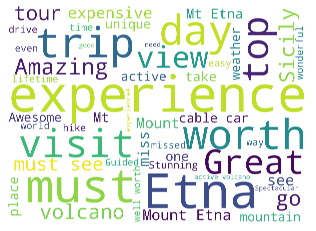

In [11]:
# Wordcloud of title

word_cloud_text = ''.join(data['title'])
print(len(word_cloud_text))
wordcloud = WordCloud(max_font_size=500, 
                      max_words=50,
                      background_color="white",
                      scale=10,
                      width=1000, 
                      height=720).generate(word_cloud_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(0,0.3)
plt.savefig(base_dir + 'output/title_wordcloud.png', dpi=400,  bbox_inches='tight')
plt.show();

1391438


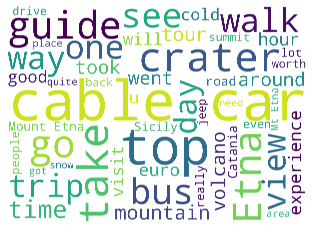

In [12]:
# Wordcloud of content

word_cloud_text = ''.join(data['content'])
print(len(word_cloud_text))
wordcloud = WordCloud(max_font_size=500, 
                      max_words=50,
                      background_color="white",
                      scale=10,
                      width=1000, 
                      height=720).generate(word_cloud_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(0,0.3)
plt.savefig(base_dir + 'output/content_wordcloud.png', dpi=400,  bbox_inches='tight')
plt.show();

# 3. NLP for title

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   author            1947 non-null   object
 1   title             1947 non-null   object
 2   content           1947 non-null   object
 3   rating            1947 non-null   int64 
 4   sentiment_rating  1947 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 76.2+ KB


In [14]:
noise_words = []
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')
noise_words.extend(eng_stop_words)

In [15]:
data

author                                              title  \
0              Teithiwr                         A hard climb, but worth it   
1     elizabethlascheid  You must see an active volcano at least once i...   
2                Anne N                    Cost of cable car to the top???   
3         doorstomanual                       Well orgainised, easy access   
4              Emilie P                   Cheap and easy way to do Mt Etna   
...                 ...                                                ...   
1942        DianaMary60                                        Rocks rock!   
1943            Yaron S                                  Unique experience   
1944            jpg1747                                      Fabulous Tour   
1945              qio_s                                 Exciting adventure   
1946         Hornepayne             Take your Time and Enjoy the Adventure   

                                                content  rating  \
0     August 2008. Arrived at Refugio Sapienza just ...       4   
1     Mount Etna is extraordinary. It is an active v...       5   
2     How much does the cable car cost from Rifugio ...       4   
3     We visited Etna with two small children in Aug...       5   
4     We were able to experience Mt Etna without spe...       5   
...                                                 ...     ...   
1942  I went in a 4-wheel drive car, in company with...       5   
1943  Very unique experience. It's not every day you...       5   
1944  We were a group of 7 - we had a great time vis...       5   
1945  I've been to Catania for 5 months with Erasmus...       5   
1946  Went on 3 different tours with Sicily Life. As...       5   

      sentiment_rating  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
1942                 0  
1943                 0  
1944                 0  
1945                 0  
1946                 0  

[1947 rows x 5 columns]

In [16]:
# Pycaret
from pycaret.nlp import *

exp_name = setup(data = data[['title', 'sentiment_rating']],  
                 target = 'title',
                 session_id = 42,
                 custom_stopwords = noise_words
                )

In [17]:
lda_title = create_model('lda', multi_core = True) # Latent Dirichlet Allocation
print('Latent Dirichlet Allocation: ', lda_title)
lda_title_data = assign_model(lda_title)

In [18]:
print('Shape of lda_title_data: ', lda_title_data.shape)
display(lda_title_data.head())
print('------')
lda_title_data.describe(include='all')

Shape of lda_title_data:  (1947, 8)


title  sentiment_rating   Topic_0   Topic_1  \
0                                hard                 0  0.125033  0.624881   
1  must see active volcano least life                 0  0.892542  0.035896   
2                  cost cable car top                 0  0.050006  0.050023   
3               orgainise easy access                 0  0.062802  0.062565   
4                      cheap easy way                 0  0.377615  0.062526   

    Topic_2   Topic_3 Dominant_Topic  Perc_Dominant_Topic  
0  0.125047  0.125039        Topic 1                 0.62  
1  0.035778  0.035784        Topic 0                 0.89  
2  0.451690  0.448281        Topic 2                 0.45  
3  0.812072  0.062560        Topic 2                 0.81  
4  0.247845  0.312015        Topic 0                 0.38

------


title  sentiment_rating      Topic_0      Topic_1      Topic_2  \
count   1947       1947.000000  1947.000000  1947.000000  1947.000000   
unique  1161               NaN          NaN          NaN          NaN   
top                        NaN          NaN          NaN          NaN   
freq     297               NaN          NaN          NaN          NaN   
mean     NaN          0.103749     0.281149     0.243977     0.223233   
std      NaN          0.305013     0.254417     0.233287     0.215291   
min      NaN          0.000000     0.023112     0.025077     0.028099   
25%      NaN          0.000000     0.083374     0.083336     0.083345   
50%      NaN          0.000000     0.129133     0.125006     0.125008   
75%      NaN          0.000000     0.416809     0.253599     0.250000   
max      NaN          1.000000     0.904630     0.874192     0.924528   

            Topic_3 Dominant_Topic  Perc_Dominant_Topic  
count   1947.000000           1947          1947.000000  
unique          NaN              4                  NaN  
top             NaN        Topic 0                  NaN  
freq            NaN            796                  NaN  
mean       0.251640            NaN             0.597488  
std        0.235264            NaN             0.189846  
min        0.023059            NaN             0.250000  
25%        0.083389            NaN             0.450000  
50%        0.125033            NaN             0.620000  
75%        0.312781            NaN             0.750000  
max        0.903700            NaN             0.920000

## Tuning number of topics

IntProgress(value=0, description='Processing: ', max=15)

Output()

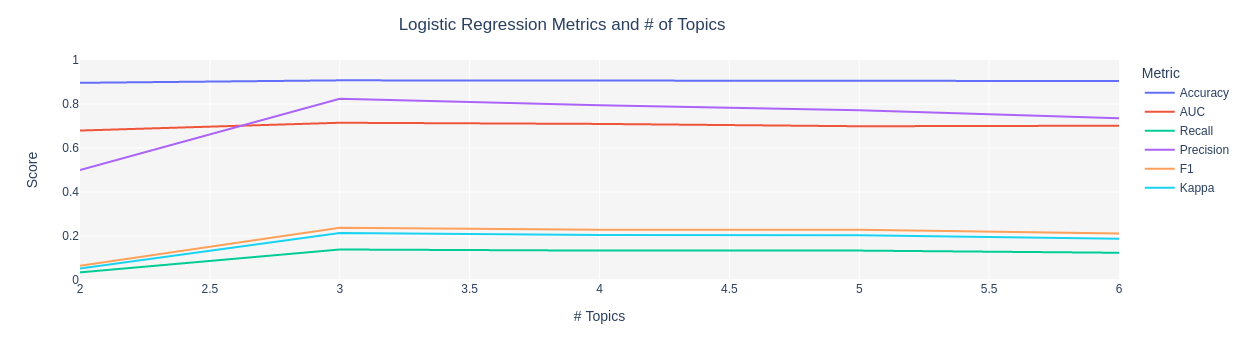

Best Model: Latent Dirichlet Allocation | # Topics: 3 | AUC : 0.7148


In [19]:
tuned_lda_title = tune_model(model = 'lda', 
                             multi_core = True, 
                             supervised_target = 'sentiment_rating',
                             custom_grid = [2,3,4,5,6],
                             optimize = 'AUC'
                             )

In [20]:
lda_title_tuned = create_model('lda', multi_core = True, num_topics=tuned_lda_title.num_topics) # Latent Dirichlet Allocation
print('Latent Dirichlet Allocation: ', lda_title_tuned)
lda_title_data_tuned = assign_model(lda_title_tuned)
lda_title_data_tuned = lda_title_data_tuned.add_prefix('Title_')
lda_title_data_tuned['Title_Dominant_Topic'] = lda_title_data_tuned['Title_Dominant_Topic'].replace(' ', '_', regex=True)

In [21]:
print('Shape of lda_title_data_tuned: ', lda_title_data_tuned.shape)
display(lda_title_data_tuned.head())
print('------')
lda_title_data_tuned.describe(include='all')

Shape of lda_title_data_tuned:  (1947, 7)


Title_title  Title_sentiment_rating  Title_Topic_0  \
0                                hard                       0       0.166959   
1  must see active volcano least life                       0       0.903365   
2                  cost cable car top                       0       0.066697   
3               orgainise easy access                       0       0.086313   
4                      cheap easy way                       0       0.810527   

   Title_Topic_1  Title_Topic_2 Title_Dominant_Topic  \
0       0.666077       0.166963              Topic_1   
1       0.048886       0.047749              Topic_0   
2       0.066723       0.866580              Topic_2   
3       0.083895       0.829793              Topic_2   
4       0.083458       0.106015              Topic_0   

   Title_Perc_Dominant_Topic  
0                       0.67  
1                       0.90  
2                       0.87  
3                       0.83  
4                       0.81

------


Title_title  Title_sentiment_rating  Title_Topic_0  Title_Topic_1  \
count         1947             1947.000000    1947.000000    1947.000000   
unique        1161                     NaN            NaN            NaN   
top                                    NaN            NaN            NaN   
freq           297                     NaN            NaN            NaN   
mean           NaN                0.103749       0.336636       0.325855   
std            NaN                0.305013       0.252868       0.245655   
min            NaN                0.000000       0.032487       0.036111   
25%            NaN                0.000000       0.111567       0.111250   
50%            NaN                0.000000       0.301544       0.271636   
75%            NaN                0.000000       0.527173       0.444200   
max            NaN                1.000000       0.912516       0.888207   

        Title_Topic_2 Title_Dominant_Topic  Title_Perc_Dominant_Topic  
count     1947.000000                 1947                1947.000000  
unique            NaN                    3                        NaN  
top               NaN              Topic_0                        NaN  
freq              NaN                  878                        NaN  
mean         0.337511                  NaN                   0.631890  
std          0.249043                  NaN                   0.171667  
min          0.038243                  NaN                   0.330000  
25%          0.111795                  NaN                   0.470000  
50%          0.329478                  NaN                   0.670000  
75%          0.479056                  NaN                   0.780000  
max          0.923599                  NaN                   0.920000

In [22]:
lda_title_data_tuned

Title_title  Title_sentiment_rating  \
0                                   hard                       0   
1     must see active volcano least life                       0   
2                     cost cable car top                       0   
3                  orgainise easy access                       0   
4                         cheap easy way                       0   
...                                  ...                     ...   
1942                                rock                       0   
1943                   unique experience                       0   
1944                       fabulous tour                       0   
1945                            exciting                       0   
1946           take time enjoy adventure                       0   

      Title_Topic_0  Title_Topic_1  Title_Topic_2 Title_Dominant_Topic  \
0          0.166959       0.666077       0.166963              Topic_1   
1          0.903365       0.048886       0.047749              Topic_0   
2          0.066697       0.066723       0.866580              Topic_2   
3          0.086313       0.083895       0.829793              Topic_2   
4          0.810527       0.083458       0.106015              Topic_0   
...             ...            ...            ...                  ...   
1942       0.167342       0.665311       0.167347              Topic_1   
1943       0.111427       0.777004       0.111569              Topic_1   
1944       0.120140       0.444584       0.435277              Topic_1   
1945       0.666086       0.166904       0.167010              Topic_0   
1946       0.066952       0.649830       0.283219              Topic_1   

      Title_Perc_Dominant_Topic  
0                          0.67  
1                          0.90  
2                          0.87  
3                          0.83  
4                          0.81  
...                         ...  
1942                       0.67  
1943                       0.78  
1944                       0.44  
1945                       0.67  
1946                       0.65  

[1947 rows x 7 columns]

# Wordclouds and bigrams for Titles

Wordcloud for Title_Topic_0
0    815
1     63
Name: Title_sentiment_rating, dtype: int64


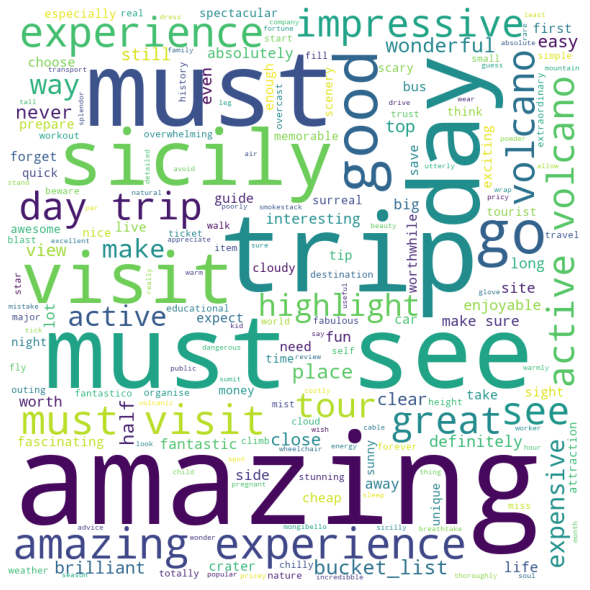

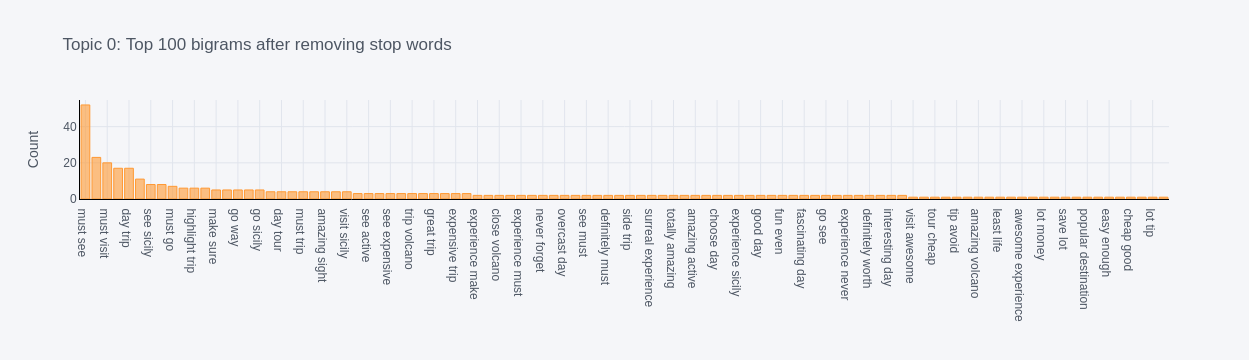

----------------------------------


Wordcloud for Title_Topic_1
0    442
1     43
Name: Title_sentiment_rating, dtype: int64


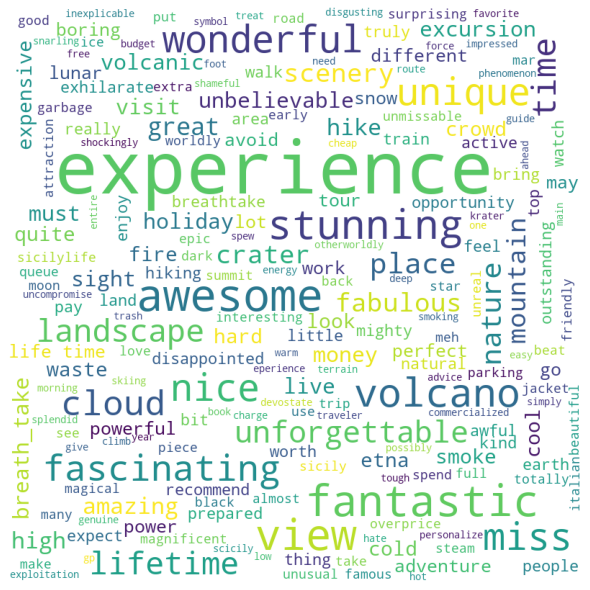

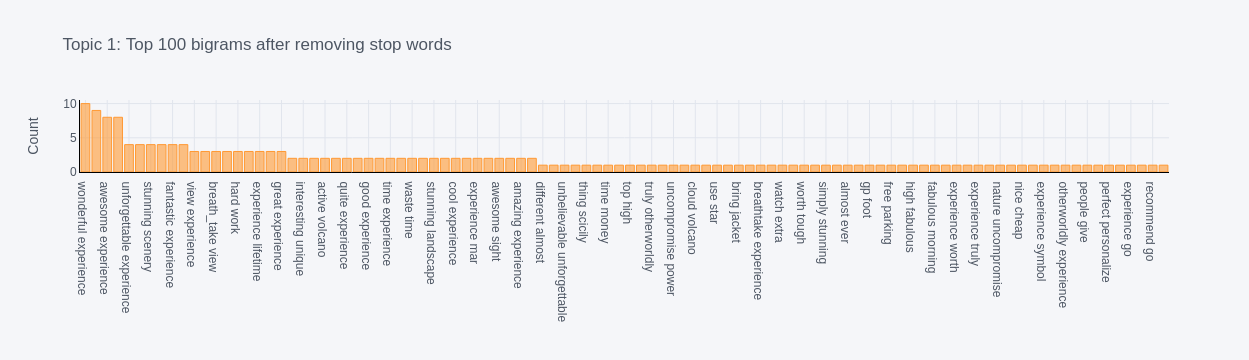

----------------------------------


Wordcloud for Title_Topic_2
0    488
1     96
Name: Title_sentiment_rating, dtype: int64


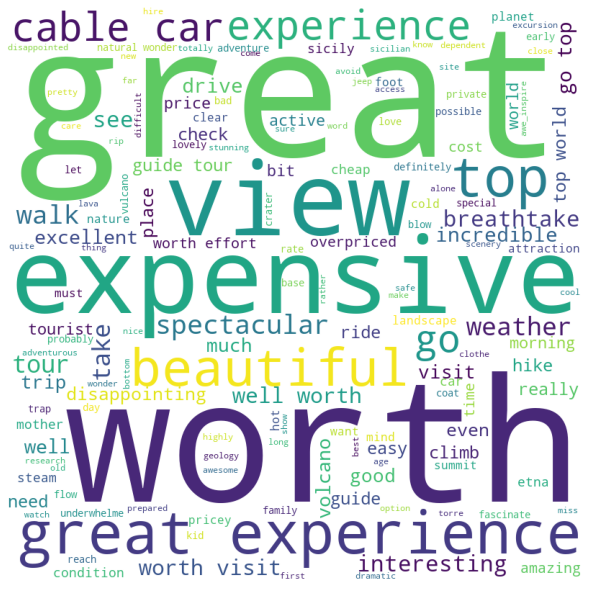

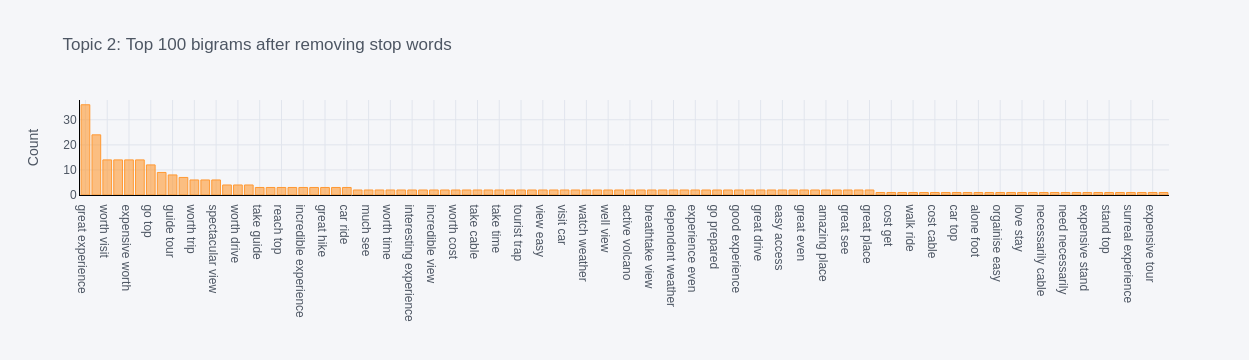

----------------------------------




In [23]:
for i in lda_title_data_tuned.filter(regex='Title_Topic_'):
    print('Wordcloud for {}'.format(i))
    title_topic = lda_title_data_tuned[lda_title_data_tuned['Title_Dominant_Topic']== i[len('Title_'):]]
    print(title_topic['Title_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_title_tuned, plot='wordcloud', topic_num=i[len('Title_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_title_tuned, plot='bigram', topic_num=i[len('Title_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

### Evaluation of the model

In [24]:
# Evaluation of the model
evaluate_model(lda_title_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

In [25]:
lda_title_data_tuned

Title_title  Title_sentiment_rating  \
0                                   hard                       0   
1     must see active volcano least life                       0   
2                     cost cable car top                       0   
3                  orgainise easy access                       0   
4                         cheap easy way                       0   
...                                  ...                     ...   
1942                                rock                       0   
1943                   unique experience                       0   
1944                       fabulous tour                       0   
1945                            exciting                       0   
1946           take time enjoy adventure                       0   

      Title_Topic_0  Title_Topic_1  Title_Topic_2 Title_Dominant_Topic  \
0          0.166959       0.666077       0.166963              Topic_1   
1          0.903365       0.048886       0.047749              Topic_0   
2          0.066697       0.066723       0.866580              Topic_2   
3          0.086313       0.083895       0.829793              Topic_2   
4          0.810527       0.083458       0.106015              Topic_0   
...             ...            ...            ...                  ...   
1942       0.167342       0.665311       0.167347              Topic_1   
1943       0.111427       0.777004       0.111569              Topic_1   
1944       0.120140       0.444584       0.435277              Topic_1   
1945       0.666086       0.166904       0.167010              Topic_0   
1946       0.066952       0.649830       0.283219              Topic_1   

      Title_Perc_Dominant_Topic  
0                          0.67  
1                          0.90  
2                          0.87  
3                          0.83  
4                          0.81  
...                         ...  
1942                       0.67  
1943                       0.78  
1944                       0.44  
1945                       0.67  
1946                       0.65  

[1947 rows x 7 columns]

In [26]:
lda_title_data_tuned.to_csv(base_dir + 'data/lda_title_data_tuned.csv', index=False)

# 4. NLP for review

In [27]:
lda_title_data_tuned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Title_title                1947 non-null   object 
 1   Title_sentiment_rating     1947 non-null   int64  
 2   Title_Topic_0              1947 non-null   float32
 3   Title_Topic_1              1947 non-null   float32
 4   Title_Topic_2              1947 non-null   float32
 5   Title_Dominant_Topic       1947 non-null   object 
 6   Title_Perc_Dominant_Topic  1947 non-null   float64
dtypes: float32(3), float64(1), int64(1), object(2)
memory usage: 83.8+ KB


In [28]:
lda_title_data_tuned

Title_title  Title_sentiment_rating  \
0                                   hard                       0   
1     must see active volcano least life                       0   
2                     cost cable car top                       0   
3                  orgainise easy access                       0   
4                         cheap easy way                       0   
...                                  ...                     ...   
1942                                rock                       0   
1943                   unique experience                       0   
1944                       fabulous tour                       0   
1945                            exciting                       0   
1946           take time enjoy adventure                       0   

      Title_Topic_0  Title_Topic_1  Title_Topic_2 Title_Dominant_Topic  \
0          0.166959       0.666077       0.166963              Topic_1   
1          0.903365       0.048886       0.047749              Topic_0   
2          0.066697       0.066723       0.866580              Topic_2   
3          0.086313       0.083895       0.829793              Topic_2   
4          0.810527       0.083458       0.106015              Topic_0   
...             ...            ...            ...                  ...   
1942       0.167342       0.665311       0.167347              Topic_1   
1943       0.111427       0.777004       0.111569              Topic_1   
1944       0.120140       0.444584       0.435277              Topic_1   
1945       0.666086       0.166904       0.167010              Topic_0   
1946       0.066952       0.649830       0.283219              Topic_1   

      Title_Perc_Dominant_Topic  
0                          0.67  
1                          0.90  
2                          0.87  
3                          0.83  
4                          0.81  
...                         ...  
1942                       0.67  
1943                       0.78  
1944                       0.44  
1945                       0.67  
1946                       0.65  

[1947 rows x 7 columns]

In [29]:
# Pycaret
from pycaret.nlp import *

exp_name = setup(data = data[['content', 'sentiment_rating']],  
                 target = 'content',
                 session_id = 42,
                 custom_stopwords = noise_words
                )

In [30]:
lda_review = create_model('lda', multi_core = True) # Latent Dirichlet Allocation
print('Latent Dirichlet Allocation: ', lda_review)
lda_review_data = assign_model(lda_review)

In [31]:
print('Shape of lda_review_data: ', lda_review_data.shape)
display(lda_review_data.head())
print('------')
lda_review_data.describe(include='all')

Shape of lda_review_data:  (1947, 8)


content  sentiment_rating  \
0  arrive make_sure allow plenty time mountain ro...                 0   
1  extraordinary active volcano beautiful landsca...                 0   
2  much cable car cost charge really look receipt...                 0   
3  small child august use company get see sight h...                 0   
4  able experience etna spend money tour research...                 0   

    Topic_0   Topic_1   Topic_2   Topic_3 Dominant_Topic  Perc_Dominant_Topic  
0  0.203031  0.516106  0.280050  0.000814        Topic 1                 0.52  
1  0.348323  0.258625  0.388983  0.004068        Topic 2                 0.39  
2  0.014000  0.959049  0.013589  0.013361        Topic 1                 0.96  
3  0.003671  0.989059  0.003641  0.003629        Topic 1                 0.99  
4  0.010188  0.969935  0.010072  0.009805        Topic 1                 0.97

------


content  sentiment_rating  \
count                                                1947       1947.000000   
unique                                               1947               NaN   
top     arrive make_sure allow plenty time mountain ro...               NaN   
freq                                                    1               NaN   
mean                                                  NaN          0.103749   
std                                                   NaN          0.305013   
min                                                   NaN          0.000000   
25%                                                   NaN          0.000000   
50%                                                   NaN          0.000000   
75%                                                   NaN          0.000000   
max                                                   NaN          1.000000   

            Topic_0      Topic_1      Topic_2      Topic_3 Dominant_Topic  \
count   1947.000000  1947.000000  1947.000000  1947.000000           1947   
unique          NaN          NaN          NaN          NaN              4   
top             NaN          NaN          NaN          NaN        Topic 1   
freq            NaN          NaN          NaN          NaN           1513   
mean       0.162939     0.706324     0.089161     0.041576            NaN   
std        0.262584     0.312538     0.191821     0.105237            NaN   
min        0.001000     0.001003     0.000569     0.000389            NaN   
25%        0.005981     0.514678     0.004984     0.004295            NaN   
50%        0.012051     0.831569     0.008946     0.007291            NaN   
75%        0.252911     0.970529     0.031610     0.014022            NaN   
max        0.996991     0.997017     0.991408     0.973901            NaN   

        Perc_Dominant_Topic  
count           1947.000000  
unique                  NaN  
top                     NaN  
freq                    NaN  
mean               0.817211  
std                0.176085  
min                0.280000  
25%                0.670000  
50%                0.890000  
75%                0.970000  
max                1.000000

## Tuning number of topics

IntProgress(value=0, description='Processing: ', max=15)

Output()

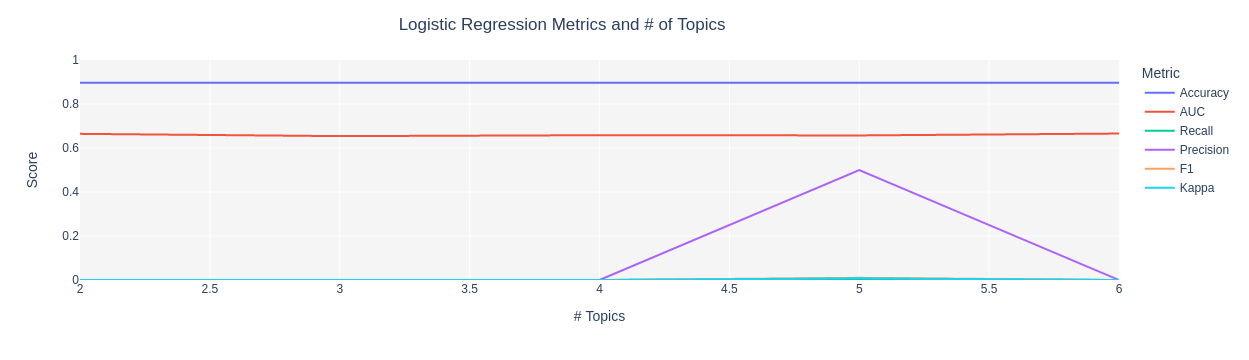

Best Model: Latent Dirichlet Allocation | # Topics: 6 | AUC : 0.6657


In [32]:
tuned_lda_review = tune_model(model = 'lda', 
                             multi_core = True, 
                             supervised_target = 'sentiment_rating',
                             custom_grid = [2,3,4,5,6],
                             optimize = 'AUC'
                             )

In [33]:
lda_review_tuned = create_model('lda', multi_core = True, num_topics=tuned_lda_review.num_topics) # Latent Dirichlet Allocation
print('Latent Dirichlet Allocation: ', lda_review_tuned)
lda_review_data_tuned = assign_model(lda_review_tuned)
lda_review_data_tuned = lda_review_data_tuned.add_prefix('Review_')
lda_review_data_tuned['Review_Dominant_Topic'] = lda_review_data_tuned['Review_Dominant_Topic'].replace(' ', '_', regex=True)

In [34]:
print('Shape of lda_review_data_tuned: ', lda_review_data_tuned.shape)
display(lda_review_data_tuned.head())
print('------')
lda_review_data_tuned.describe(include='all')

Shape of lda_review_data_tuned:  (1947, 10)


Review_content  Review_sentiment_rating  \
0  arrive make_sure allow plenty time mountain ro...                        0   
1  extraordinary active volcano beautiful landsca...                        0   
2  much cable car cost charge really look receipt...                        0   
3  small child august use company get see sight h...                        0   
4  able experience etna spend money tour research...                        0   

   Review_Topic_0  Review_Topic_1  Review_Topic_2  Review_Topic_3  \
0        0.305727        0.452438        0.035940        0.000527   
1        0.808129        0.002637        0.181372        0.002620   
2        0.008884        0.955828        0.008824        0.008817   
3        0.201684        0.788972        0.002331        0.002334   
4        0.006472        0.967756        0.006460        0.006437   

   Review_Topic_4  Review_Topic_5 Review_Dominant_Topic  \
0        0.204842        0.000526               Topic_1   
1        0.002621        0.002621               Topic_0   
2        0.008830        0.008818               Topic_1   
3        0.002343        0.002336               Topic_1   
4        0.006439        0.006437               Topic_1   

   Review_Perc_Dominant_Topic  
0                        0.45  
1                        0.81  
2                        0.96  
3                        0.79  
4                        0.97

------


Review_content  \
count                                                1947   
unique                                               1947   
top     arrive make_sure allow plenty time mountain ro...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

        Review_sentiment_rating  Review_Topic_0  Review_Topic_1  \
count               1947.000000     1947.000000     1947.000000   
unique                      NaN             NaN             NaN   
top                         NaN             NaN             NaN   
freq                        NaN             NaN             NaN   
mean                   0.103749        0.159911        0.685372   
std                    0.305013        0.269285        0.317527   
min                    0.000000        0.000251        0.000642   
25%                    0.000000        0.003751        0.506225   
50%                    0.000000        0.007651        0.798452   
75%                    0.000000        0.220686        0.959371   
max                    1.000000        0.996789        0.996828   

        Review_Topic_2  Review_Topic_3  Review_Topic_4  Review_Topic_5  \
count      1947.000000     1947.000000     1947.000000     1947.000000   
unique             NaN             NaN             NaN             NaN   
top                NaN             NaN             NaN             NaN   
freq               NaN             NaN             NaN             NaN   
mean          0.051011        0.031228        0.041873        0.030604   
std           0.137185        0.095256        0.115014        0.100161   
min           0.000251        0.000250        0.000251        0.000356   
25%           0.002950        0.002753        0.002951        0.002789   
50%           0.005079        0.004658        0.005075        0.004663   
75%           0.009857        0.008381        0.009849        0.008360   
max           0.979957        0.967728        0.985460        0.981749   

       Review_Dominant_Topic  Review_Perc_Dominant_Topic  
count                   1947                 1947.000000  
unique                     6                         NaN  
top                  Topic_1                         NaN  
freq                    1513                         NaN  
mean                     NaN                    0.803919  
std                      NaN                    0.174409  
min                      NaN                    0.280000  
25%                      NaN                    0.660000  
50%                      NaN                    0.860000  
75%                      NaN                    0.970000  
max                      NaN                    1.000000

In [35]:
lda_review_data_tuned

Review_content  \
0     arrive make_sure allow plenty time mountain ro...   
1     extraordinary active volcano beautiful landsca...   
2     much cable car cost charge really look receipt...   
3     small child august use company get see sight h...   
4     able experience etna spend money tour research...   
...                                                 ...   
1942  go wheel_drive car company guide family old me...   
1943  unique experience day get chance climb active ...   
1944  group great time visit place big tour bus ente...   
1945  exchange program active volcano occasionally e...   
1946  go different tour sicily life well provide tra...   

      Review_sentiment_rating  Review_Topic_0  Review_Topic_1  Review_Topic_2  \
0                           0        0.305727        0.452438        0.035940   
1                           0        0.808129        0.002637        0.181372   
2                           0        0.008884        0.955828        0.008824   
3                           0        0.201684        0.788972        0.002331   
4                           0        0.006472        0.967756        0.006460   
...                       ...             ...             ...             ...   
1942                        0        0.003363        0.983130        0.003388   
1943                        0        0.008020        0.960081        0.007958   
1944                        0        0.012927        0.935465        0.012979   
1945                        0        0.722724        0.225408        0.003811   
1946                        0        0.280374        0.003301        0.706437   

      Review_Topic_3  Review_Topic_4  Review_Topic_5 Review_Dominant_Topic  \
0           0.000527        0.204842        0.000526               Topic_1   
1           0.002620        0.002621        0.002621               Topic_0   
2           0.008817        0.008830        0.008818               Topic_1   
3           0.002334        0.002343        0.002336               Topic_1   
4           0.006437        0.006439        0.006437               Topic_1   
...              ...             ...             ...                   ...   
1942        0.003375        0.003363        0.003381               Topic_1   
1943        0.008005        0.007979        0.007958               Topic_1   
1944        0.012906        0.012856        0.012867               Topic_1   
1945        0.040419        0.003810        0.003828               Topic_0   
1946        0.003292        0.003286        0.003310               Topic_2   

      Review_Perc_Dominant_Topic  
0                           0.45  
1                           0.81  
2                           0.96  
3                           0.79  
4                           0.97  
...                          ...  
1942                        0.98  
1943                        0.96  
1944                        0.94  
1945                        0.72  
1946                        0.71  

[1947 rows x 10 columns]

# Wordclouds and bigrams for Reviews

Wordcloud for Review_Topic_0
0    253
1     29
Name: Review_sentiment_rating, dtype: int64


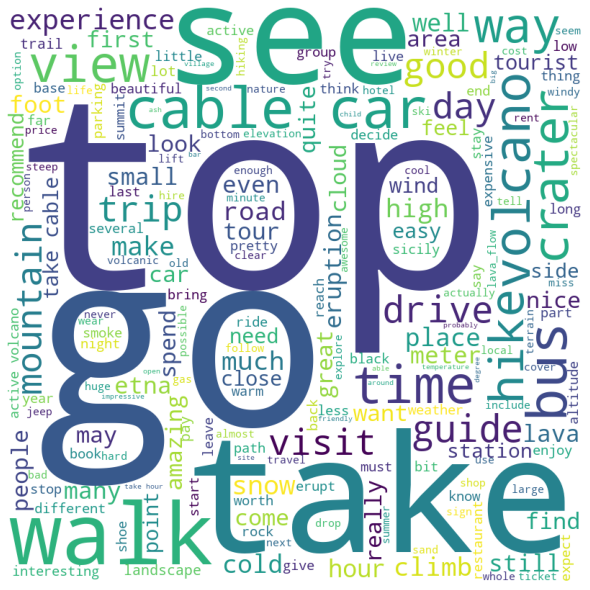

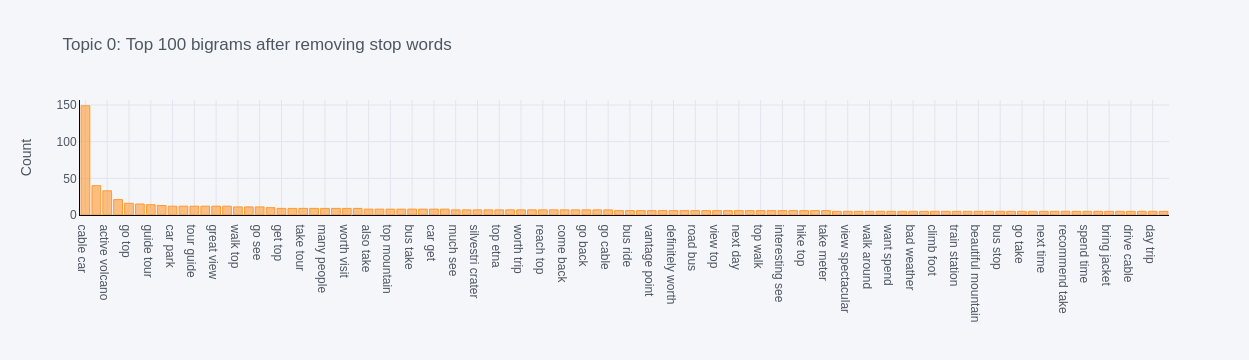

----------------------------------


Wordcloud for Review_Topic_1
0    1351
1     162
Name: Review_sentiment_rating, dtype: int64


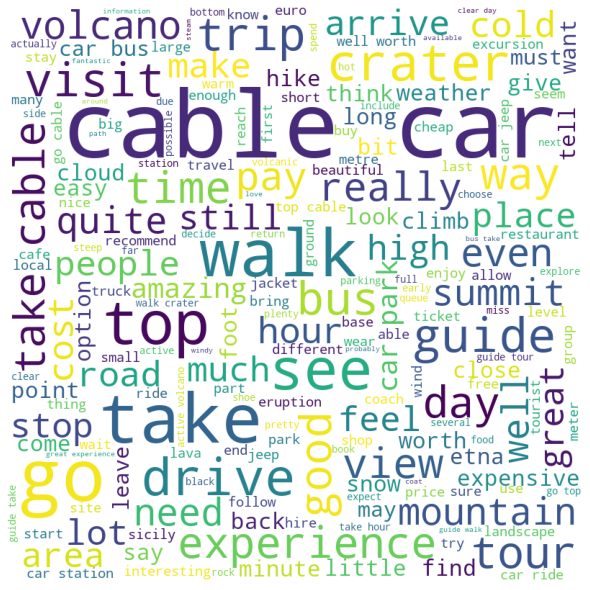

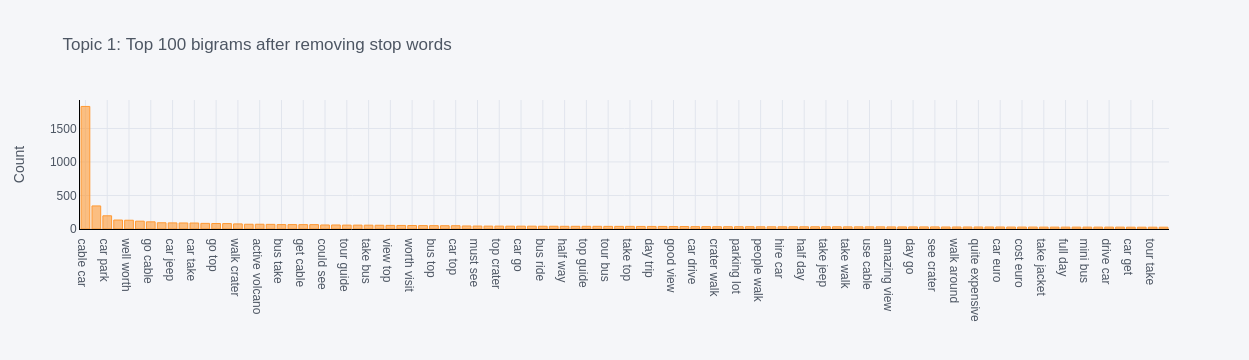

----------------------------------


Wordcloud for Review_Topic_2
0    59
1     5
Name: Review_sentiment_rating, dtype: int64


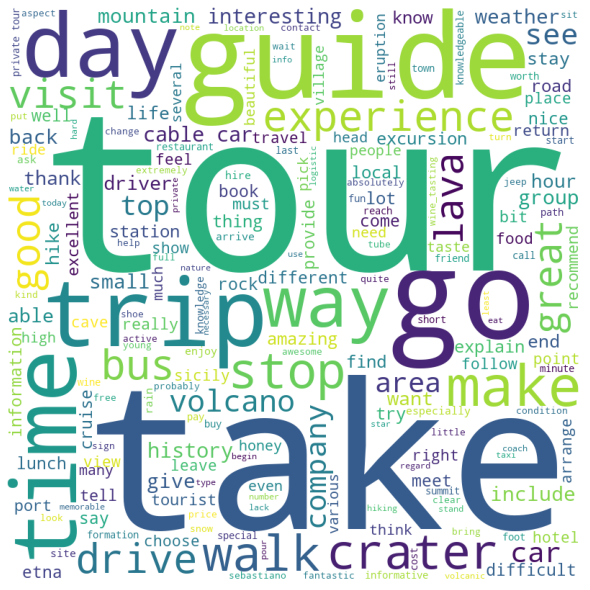

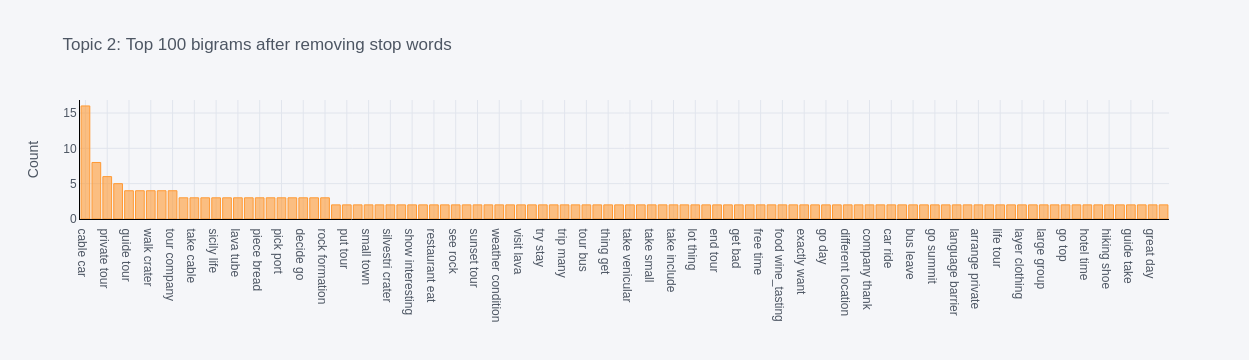

----------------------------------


Wordcloud for Review_Topic_3
0    22
Name: Review_sentiment_rating, dtype: int64


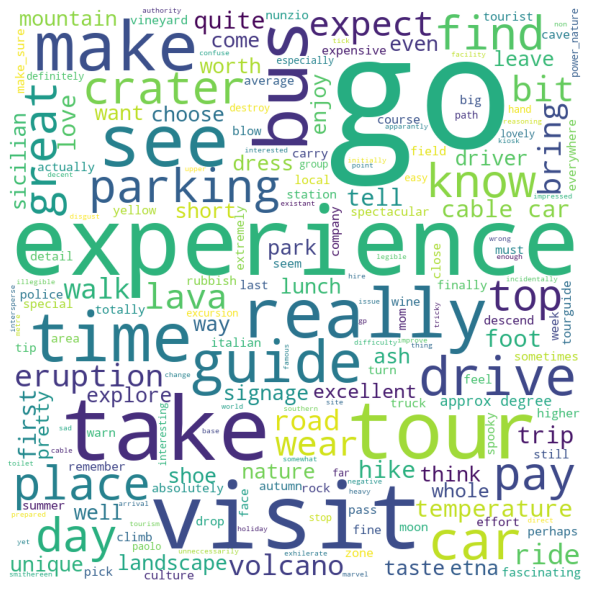

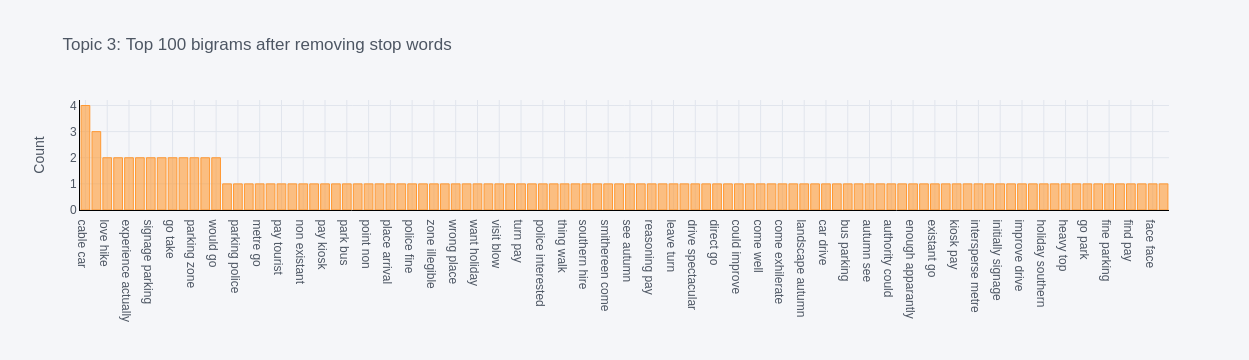

----------------------------------


Wordcloud for Review_Topic_4
0    32
1     5
Name: Review_sentiment_rating, dtype: int64


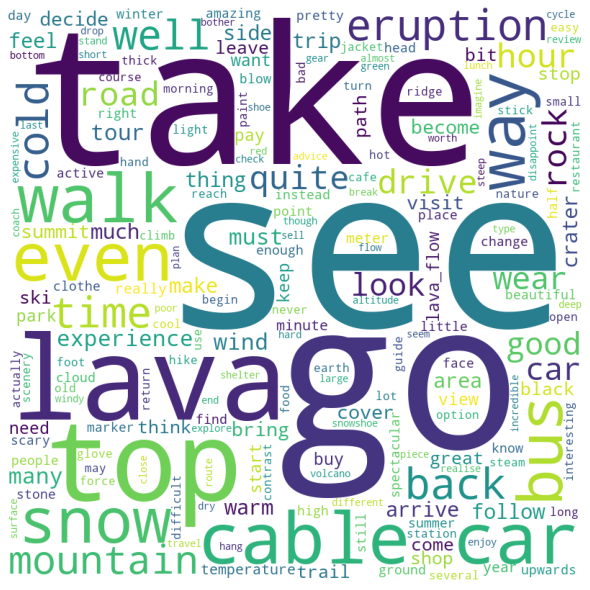

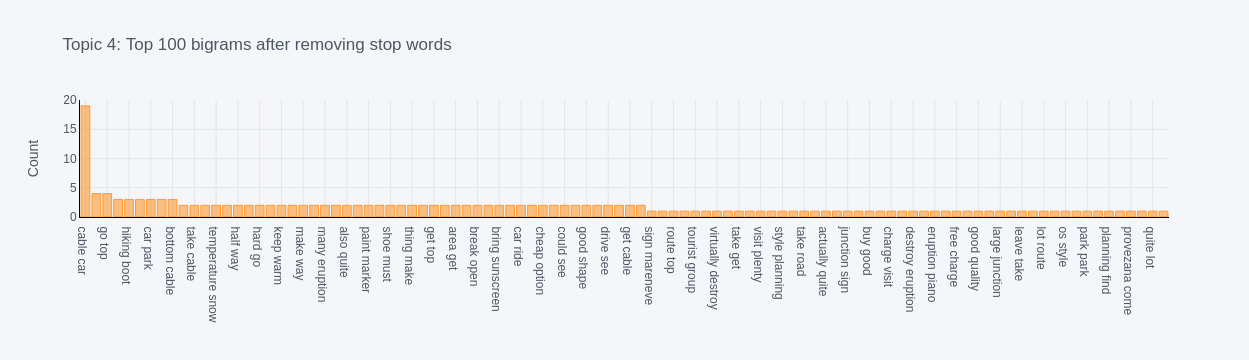

----------------------------------


Wordcloud for Review_Topic_5
0    28
1     1
Name: Review_sentiment_rating, dtype: int64


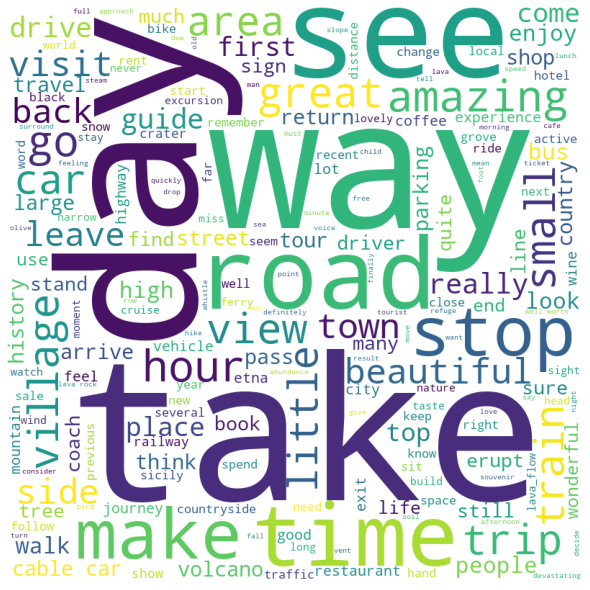

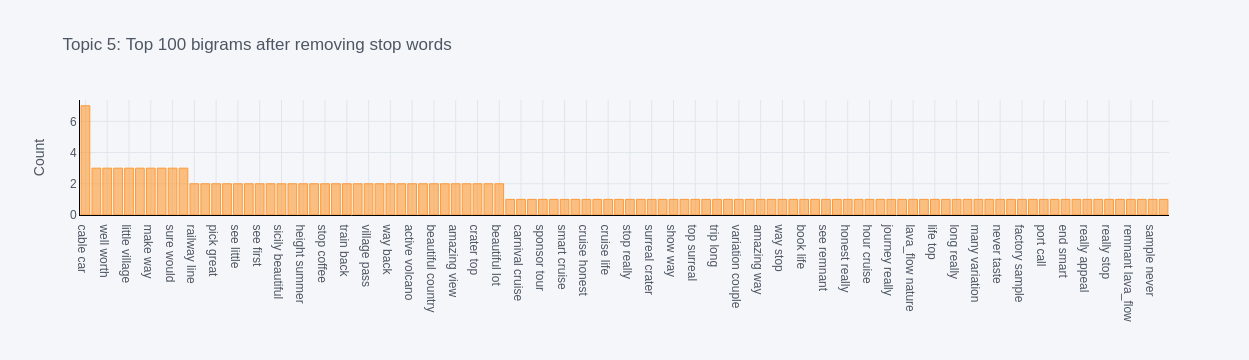

----------------------------------




In [36]:
for i in lda_review_data_tuned.filter(regex='Review_Topic_'):
    print('Wordcloud for {}'.format(i))
    review_topic = lda_review_data_tuned[lda_review_data_tuned['Review_Dominant_Topic']== i[len('Review_'):]]
    print(review_topic['Review_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_review_tuned, plot='wordcloud', topic_num=i[len('Review_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_review_tuned, plot='bigram', topic_num=i[len('Review_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

### Evaluation of the model

In [37]:
# Evaluation of the model
evaluate_model(lda_review_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

In [38]:
lda_review_data_tuned

Review_content  \
0     arrive make_sure allow plenty time mountain ro...   
1     extraordinary active volcano beautiful landsca...   
2     much cable car cost charge really look receipt...   
3     small child august use company get see sight h...   
4     able experience etna spend money tour research...   
...                                                 ...   
1942  go wheel_drive car company guide family old me...   
1943  unique experience day get chance climb active ...   
1944  group great time visit place big tour bus ente...   
1945  exchange program active volcano occasionally e...   
1946  go different tour sicily life well provide tra...   

      Review_sentiment_rating  Review_Topic_0  Review_Topic_1  Review_Topic_2  \
0                           0        0.305727        0.452438        0.035940   
1                           0        0.808129        0.002637        0.181372   
2                           0        0.008884        0.955828        0.008824   
3                           0        0.201684        0.788972        0.002331   
4                           0        0.006472        0.967756        0.006460   
...                       ...             ...             ...             ...   
1942                        0        0.003363        0.983130        0.003388   
1943                        0        0.008020        0.960081        0.007958   
1944                        0        0.012927        0.935465        0.012979   
1945                        0        0.722724        0.225408        0.003811   
1946                        0        0.280374        0.003301        0.706437   

      Review_Topic_3  Review_Topic_4  Review_Topic_5 Review_Dominant_Topic  \
0           0.000527        0.204842        0.000526               Topic_1   
1           0.002620        0.002621        0.002621               Topic_0   
2           0.008817        0.008830        0.008818               Topic_1   
3           0.002334        0.002343        0.002336               Topic_1   
4           0.006437        0.006439        0.006437               Topic_1   
...              ...             ...             ...                   ...   
1942        0.003375        0.003363        0.003381               Topic_1   
1943        0.008005        0.007979        0.007958               Topic_1   
1944        0.012906        0.012856        0.012867               Topic_1   
1945        0.040419        0.003810        0.003828               Topic_0   
1946        0.003292        0.003286        0.003310               Topic_2   

      Review_Perc_Dominant_Topic  
0                           0.45  
1                           0.81  
2                           0.96  
3                           0.79  
4                           0.97  
...                          ...  
1942                        0.98  
1943                        0.96  
1944                        0.94  
1945                        0.72  
1946                        0.71  

[1947 rows x 10 columns]

In [39]:
lda_review_data_tuned.to_csv(base_dir + 'data/lda_review_data_tuned.csv', index=False)